# State space analysis on RNNs with drift

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Wedge, FancyArrowPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import minimize
from scipy.interpolate import griddata
from scipy.stats import wilcoxon, pearsonr

import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW

from dynamic_bias import utils
from dynamic_bias.analyses.behavior import PsychometricFunction
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/rnn")

# rnn data
ra = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/demo_rnn_activity.pickle')
ss = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_state_space.pickle')
ss_s = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/results_state_space_strengths.pickle')
params = utils.load(f'{utils.ORIGIN}/data/outputs/rnn/params_connectivity.pickle')

# human behavior
behavior = utils.load_behavior()

downloading data/outputs/rnn...
data/outputs/rnn already exists. Skipping download...
downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...


---
## State dynamics with drift

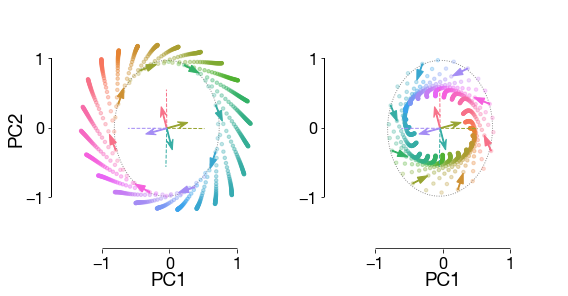

In [3]:
# visualization params
strt         = 39   # starting time step 
dura         = 29   # duration time steps
scale_center = 1.0
scale_length = 0.1
scale_ref    = 0.6
scale_stm    = 0.3

# make ellipse
rrr = np.stack([ss['het_r1_cw'][(strt-2):(strt+1),s,1].mean(axis=0) for s in range(24)])
center = np.mean(rrr, axis=0)
eparams = utils.fit_centered_ellipse( *(rrr-center).T )
rrr = utils.rotate(utils.harmonics(num=250).T, phi=eparams['phi'], w=eparams['w']).T + center[:,None]

# align state space
stim_list  = np.linspace(0,np.pi*2,num=24,endpoint=False)
ref_inputs = np.roll(ss['ref_input'], 1, axis=0)
ref_inputs = (ref_inputs - np.roll(ref_inputs, 12, axis=0))/2.

# plot
fig, ax = plt.subplots(1,2)
utils.set_size([6,3])

## [1] draw ellipse
for i in range(2): 
    ax[i].plot(rrr[1], rrr[0], color='gray', linestyle='dotted', linewidth=0.9, zorder=-3)

## [2] draw reference directions 
for s in np.arange(24,step=6):      
    vec = ss['het_r2'][strt,s,0,:]

    for i in range(2):
        ax[i].arrow(*center[::-1], *(ref_inputs[s][::-1]*scale_ref), color=utils.HUSL.colors[s], 
                    width=0.012, head_width=0.1, zorder=3, overhang=0.4)
        ax[i].plot([center[1], vec[1]*scale_stm + center[1]], [center[0], vec[0]*scale_stm + center[0]], 
                   color=utils.HUSL.colors[s], linewidth=1, linestyle='dashed' )

## [3] draw population representations
for s in np.arange(24): 
    transw = ss['het_r1_cw'] [strt:(strt+dura),s,0,:]
    transl = ss['het_r1_ccw'][strt:(strt+dura),s,0,:]
    ax[0].scatter(transw[:,1], transw[:,0], alpha=np.linspace(0,1,40)[10:],
                  color=utils.HUSL.colors[s], s=12)
    ax[1].scatter(transl[:,1], transl[:,0], alpha=np.linspace(0,1,40)[10:],
                  color=utils.HUSL.colors[s], s=12)

    if s % 3 == 0:
        p, dp = utils.arrow(transw[0,::-1], transw[4,::-1], project=False)
        ax[0].arrow(*(p*scale_center), *(dp*scale_length), 
                    width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])
        p, dp = utils.arrow(transl[0,::-1], transl[4,::-1], project=False)
        ax[1].arrow(*(p*scale_center), *(dp*scale_length), 
                    width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])

for i in range(2): 
    ax[i].set_xlim([-1.75,1.75])
    ax[i].set_ylim([-1.75,1.75])
    utils.draw_publish_axis(ax[i], xrange=(-1,1), yrange=(-1,1), xticks=[-1,0,1], yticks=[-1,0,1])

if utils.LABEL:
    ax[0].set_ylabel("PC2", labelpad=0)
    ax[0].set_xlabel("PC1", labelpad=0)
    ax[1].set_xlabel("PC1", labelpad=0)

plt.savefig(f'{utils.DIR_FIGURE}/fig8ab.pdf', bbox_inches='tight', transparent=True)
plt.show()

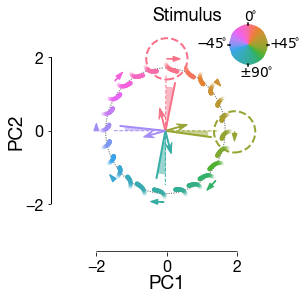

In [4]:
# visualization params
strt         = 39   # starting time step 
dura         = 29   # duration time steps
scale_center = 1.1
scale_length = 1.7
scale_ref    = 1.2
scale_stm    = 0.8

# make ellipse
rrr = np.stack([ss['het_r2'][strt:(strt+dura),s,1].mean(axis=0) for s in range(24)])
center = np.mean(rrr, axis=0)
eparams = utils.fit_centered_ellipse( *(rrr-center).T )
rrr = utils.rotate(utils.harmonics(num=250).T, phi=eparams['phi'], w=eparams['w']).T + center[:,None]

# plot
f = plt.figure()
ax = plt.gca()
utils.set_size([3,3])

## [1] draw ellipse
for i in range(2): 
    ax.plot(rrr[1], rrr[0], color='gray', linestyle='dotted', linewidth=0.9, zorder=-3)

## [2] draw reference directions 
for s in np.arange(24,step=6): 
    ax.arrow(*center[::-1], *(ref_inputs[s][::-1]*scale_ref), color=utils.HUSL.colors[s], 
             width=0.024, head_width=0.2, zorder=3, overhang=0.4)

## [3] draw population representations
for s in np.arange(24): 
    vec = ss['het_r2'][strt:(strt+dura),s,0]
    ax.scatter(vec[:,1], vec[:,0], alpha=np.linspace(0,1,30), color=utils.HUSL.colors[s], s=12)

    if s in [0,6,12,18]:
        ## draw first & last lines
        ax.plot( [center[1], vec[ 0,1]*scale_stm], [center[0], vec[ 0,0]*scale_stm], 
                 color=utils.HUSL.colors[s], linewidth=1, linestyle='dashed' )
        ax.plot( [center[1], vec[-1,1]*scale_stm], [center[0], vec[-1,0]*scale_stm], 
                 color=utils.HUSL.colors[s], linewidth=2 )

        ## draw bias angle
        ang1 = np.arctan2(vec[ 0,0], vec[ 0,1])
        ang2 = np.arctan2(vec[-1,0], vec[-1,1])
        wedge = Wedge(center=[0,0], r=0.01, alpha=0.5,
                      theta1=np.rad2deg(utils.wrap(ang2-np.pi)), 
                      theta2=np.rad2deg(utils.wrap(ang1-np.pi)), 
                      width=1.2, lw=0, color=utils.HUSL.colors[s], transform=ax.transData)
        ax.add_patch(wedge)
    
    if s % 3 == 0:
        p, dp = utils.arrow(np.mean(vec[:10,::-1],axis=0), np.mean(vec[-10:,::-1],axis=0))
        ax.arrow(*(p*scale_center), *(dp*scale_length), 
                  width=0.02, head_width=0.14, zorder=3, color=utils.HUSL.colors[s],
                 length_includes_head=True)

    if s in [0,6]:
        ax.scatter(*(p*scale_center), s=1700, facecolors='none', 
                   edgecolors=utils.HUSL.colors[s], linestyle='dashed', lw=2, zorder=-4)

ax.set_xlim([-3.3,3.3])
ax.set_ylim([-3.3,3.3])
utils.draw_publish_axis(ax, xrange=(-2,2), yrange=(-2,2), xticks=[-2,0,2], yticks=[-2,0,2])

if utils.LABEL:
    ax.set_ylabel("PC2", labelpad=0)
    ax.set_xlabel("PC1", labelpad=0)


# Create inset
inset_ax = inset_axes(ax, width="25%", height="25%", loc='upper right')

x, y, r = 0, 0, 1
re, im  = np.mgrid[-1:2:100j, -1:2:100j]
angle   = np.angle(re + 1j*im)
angle   = (angle - np.pi/2.) % (2*np.pi)
cmap    = LinearSegmentedColormap.from_list('', utils.HUSL.colors)
img     = inset_ax.pcolormesh(re, im, -angle, shading='auto', cmap=cmap)

# Change the wedge to cover the full circle
wedge = Wedge(center=(x, y), r=r, theta1=0, theta2=360, width=1., clip_on=False, transform=inset_ax.transData)
img.set_clip_path(wedge)
inset_ax.use_sticky_edges = False
inset_ax.margins(x=0.05, y=0.05)
inset_ax.set_xlim([-1.5, 1.5])
inset_ax.set_ylim([-1.5, 1.5])

dd = 0.05
for ang in [np.pi/2., -np.pi/2., np.pi, 0]:
    inset_ax.plot([np.cos(ang)*(1.-dd), np.cos(ang)*(1.+dd)], 
                  [np.sin(ang)*(1.-dd), np.sin(ang)*(1.+dd)], color='k', zorder=3)

ax.text(-0.4,3.0, 'Stimulus', size=18)
inset_ax.text(np.cos(np.pi/2.)-0.20,  np.sin(np.pi/2.)+0.15, r'$0\!\!^\circ$', size=14)
inset_ax.text(np.cos(0)+0.08, np.sin(0)-0.15, r'$+\!45\!\!^\circ$', size=14)
inset_ax.text(np.cos(np.pi)-1.7, np.sin(np.pi)-0.15, r'$-\!45\!\!^\circ$', size=14)
inset_ax.text(np.cos(-np.pi/2.)-0.50, np.sin(-np.pi/2.)-0.6, r'$\pm90\!\!^\circ$', size=14)
inset_ax.axis('off')

plt.savefig(f'{utils.DIR_FIGURE}/fig8c.pdf', bbox_inches='tight', transparent=True)
plt.show()

---
## Linear choice-induced bias under drift

In [5]:
# visualization params
strt   = 39    # starting time step 
gamr   = 0.60  # strength of reference
gamn   = 1.20  # coefficient after normalization of reference
s      = 0     # stimulus index (in this case 0°)
warp   = params['J_param_het']['J02'][1][0] / params['J_param_het']['J02'][1][1] # warp coefficient 
w_xy   = np.array([1,warp])
rvec   = -np.pi/12.      # absolute reference orientation (in direction space)
origin = np.array([0,0]) 

#
stim_list  = np.linspace(0,np.pi*2,num=24,endpoint=False)
_r1cw  = ss['hom_r1_cw'][strt,:,0]
_r1ccw = ss['hom_r1_ccw'][strt,:,0]

# starting points
w_phi = utils.wrap(np.arctan2(_r1cw[s,0],  _r1cw[s,1] ) + np.pi/12.*s)
l_phi = utils.wrap(np.arctan2(_r1ccw[s,0], _r1ccw[s,1]) + np.pi/12.*s)

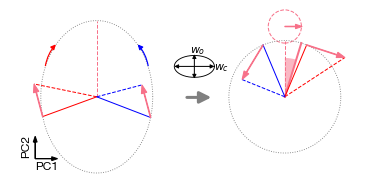

In [6]:
f,ax = plt.subplots(1,2, gridspec_kw={'wspace': 0.05})
utils.set_size([5.1,2.5])

# [0] relevant quantities
rvec0 = np.array( [np.sin(rvec),  np.cos(rvec)] )
w_p0  = np.array( [w_xy[0]*np.cos(w_phi), w_xy[1]*np.sin(w_phi)] )
l_p0  = np.array( [w_xy[0]*np.cos(l_phi), w_xy[1]*np.sin(l_phi)] )

## rotations 
### phi contribution + 90°
w_p1  = utils.rotate(w_p0,  -(params['J_param_het']['J20'][0]-np.pi/2.)+params['J_param_het']['J02'][0], 1./w_xy)
l_p1  = utils.rotate(l_p0,  -(params['J_param_het']['J21'][0]+np.pi/2.)+params['J_param_het']['J12'][0], 1./w_xy)
rvec1 = utils.rotate(rvec0, -(params['J_param_het']['J20'][0]-np.pi/2.)+params['J_param_het']['J02'][0], 1./w_xy)
rvec2 = utils.rotate(rvec0, -(params['J_param_het']['J21'][0]+np.pi/2.)+params['J_param_het']['J12'][0], 1./w_xy)
rvec1 = gamn * rvec1 / np.linalg.norm(rvec1)
rvec2 = gamn * rvec2 / np.linalg.norm(rvec2)

# [1] draw the circle
lll = np.linspace(0,np.pi*2,250)
ccc = np.array([np.cos(lll), np.sin(lll)])
ax[0].plot(w_xy[0]*ccc[0], w_xy[1]*ccc[1], color='gray', linestyle='dotted', linewidth=0.9)
ax[1].plot(ccc[0], ccc[1], color='gray', linestyle='dotted', linewidth=0.9)

# [2] upright stimulus vector
ax[0].plot([0,0], [0,w_xy[1]], color=utils.HUSL.colors[s], linewidth=1, linestyle='dashed')
ax[1].plot([0,0], [0,1], color=utils.HUSL.colors[s], linewidth=1, linestyle='dashed')

# [3] initial state [red, blue]
for i in range(2):
    ax[i].plot(*zip(origin, [w_p0,w_p1][i]), color='red', linewidth=1, zorder=3)
    ax[i].plot(*zip(origin, [l_p0,l_p1][i]), color='blue', linewidth=1, zorder=3)

# [4] reference inputs
for i in range(2):
    ax[i].arrow(*([w_p0,w_p1][i]), *(gamr*[rvec0,rvec1][i]), 
             length_includes_head=True, width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])
    ax[i].arrow(*([l_p0,l_p1][i]), *(gamr*[rvec0,rvec2][i]), 
             length_includes_head=True, width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])

# [5] r(CW), r(CCW)
for i in range(2):
    p_cw  = [w_p0,w_p1][i]+gamr*[rvec0,rvec1][i]
    p_ccw = [l_p0,l_p1][i]+gamr*[rvec0,rvec2][i]
    ax[i].plot(*zip(origin, p_cw),  color='red',  linewidth=1, linestyle='dashed')
    ax[i].plot(*zip(origin, p_ccw), color='blue', linewidth=1, linestyle='dashed')

## add "phi1" wedge
phi_ccw = np.arctan2( l_p1[1], l_p1[0] )

## add "bias" wedge
p_sum = p_ccw+p_cw
p_phi = np.arctan2(p_sum[1], p_sum[0])
wedge = Wedge(center=(0,0), r=0.01, alpha=0.5,
              theta1=np.rad2deg(utils.wrap(p_phi    - np.pi)), 
              theta2=np.rad2deg(utils.wrap(np.pi/2. - np.pi)), 
              width=.7, lw=0, color=utils.HUSL.colors[s], transform=ax[1].transData)
ax[1].add_patch(wedge)

## add parallelogram
ax[1].plot(*zip(origin, p_sum / np.linalg.norm(p_sum)),  linewidth=2, color=utils.HUSL.colors[s])


# [6] set lims
for i in range(2):
    ax[i].set_xlim([-1.6,1.6])
    ax[i].set_ylim([-1.6,1.6])
    ax[i].axis('off')
    
# [7] add moving arrows
for angs, ange, curv, col in zip(
    [np.pi*(3/8), -np.pi*(3/8)], [-np.pi/8, np.pi/8], [-0.16,0.16], ['red', 'blue']):
    a1  = np.pi/2 + angs
    a2  = a1 + ange
    c1  = w_xy*np.array([np.cos(a1), np.sin(a1)])
    c2  = w_xy*np.array([np.cos(a2), np.sin(a2)])
    arr = FancyArrowPatch(c1, c2, connectionstyle=f"arc3,rad={curv}", arrowstyle='-|>',
                          mutation_scale=10, lw=1.2, color=col, zorder=4)
    ax[0].add_patch(arr)
    
# [8] add bias arrow
chi = p_sum[0] # projection of the bias onto x axis
ax[1].arrow( 0,1.25, chi,0,
             width=0.01, head_width=0.08, zorder=3, 
             color=utils.HUSL.colors[s], length_includes_head=True)
ax[1].scatter( 0,1.25, s=1100, facecolors='none', 
               edgecolors=utils.HUSL.colors[s], linestyle='dashed', lw=1, zorder=-4)

# [9] draw the transformation ellipse on the inset axis
w_xy2 = w_xy**2 # visualization purpose
ax_inset = f.add_axes([0.41, 0.52, 0.22, 0.22])  # [left, bottom, width, height]
ax_inset.plot(w_xy2[1]*ccc[0], w_xy2[0]*ccc[1], color='k', linewidth=0.9)
ax_inset.annotate(text='', xy=[-w_xy2[1]*1.1, 0], xytext=[w_xy2[1]*1.1, 0], arrowprops=dict(color='k', mutation_scale=8, arrowstyle='<|-|>'))
ax_inset.annotate(text='', xy=[0, -w_xy2[0]*1.3], xytext=[0, w_xy2[0]*1.3], arrowprops=dict(color='k', mutation_scale=8, arrowstyle='<|-|>'))
ax_inset.set_xlim([-2.4, 2.4])
ax_inset.set_ylim([-2.4, 2.4])
ax_inset.set_aspect('equal', adjustable='box')
ax_inset.text(1.8, -0.3, r'$w_c$', fontsize=11)
ax_inset.text(-0.4, 1.25, r'$w_o$', fontsize=11)
ax_inset.axis('off')
arrow = FancyArrowPatch((0.50, 0.5), (0.56, 0.5), mutation_scale=24, lw=3, color='gray', arrowstyle='-|>', transform=f.transFigure)
f.patches.append(arrow)

# [*] add axis
ax[0].arrow(*[-1.1,-1.1], *[0.4,0], width=0.001, head_width=0.07, color='k', length_includes_head=True)
ax[0].arrow(*[-1.1,-1.1], *[0,0.4], width=0.001, head_width=0.07, color='k', length_includes_head=True)
ax[0].text(-1.10,-1.30, 'PC1', fontsize=12)
ax[0].text(-1.35,-1.05, 'PC2', fontsize=12, rotation='vertical')

plt.savefig(f'{utils.DIR_FIGURE}/fig8d.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [7]:
# visualization params (updated)
s     = 6     # stimulus index (in this case 0°)
warp  = params['J_param_het']['J02'][1][0] / params['J_param_het']['J02'][1][1] # warp coefficient 
w_xy  = np.array([warp,1])
w_phi = utils.wrap(np.arctan2(_r1cw[s,0],  _r1cw[s,1] ) + np.pi/12.*s)
l_phi = utils.wrap(np.arctan2(_r1ccw[s,0], _r1ccw[s,1]) + np.pi/12.*s)

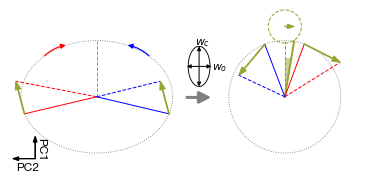

In [8]:
f,ax = plt.subplots(1,2, gridspec_kw={'wspace': 0.05})
utils.set_size([5.1,2.5])

# [0] relevant quantities
rvec0 = np.array( [np.sin(rvec),  np.cos(rvec)] )
w_p0  = np.array( [w_xy[0]*np.cos(w_phi), w_xy[1]*np.sin(w_phi)] )
l_p0  = np.array( [w_xy[0]*np.cos(l_phi), w_xy[1]*np.sin(l_phi)] )

## rotations 
### phi contribution + 90°
w_p1  = utils.rotate(w_p0,  -(params['J_param_het']['J20'][0]-np.pi/2.)+params['J_param_het']['J02'][0], 1./w_xy)
l_p1  = utils.rotate(l_p0,  -(params['J_param_het']['J21'][0]+np.pi/2.)+params['J_param_het']['J12'][0], 1./w_xy)
rvec1 = utils.rotate(rvec0, -(params['J_param_het']['J20'][0]-np.pi/2.)+params['J_param_het']['J02'][0], 1./w_xy)
rvec2 = utils.rotate(rvec0, -(params['J_param_het']['J21'][0]+np.pi/2.)+params['J_param_het']['J12'][0], 1./w_xy)
rvec1 = gamn * rvec1 / np.linalg.norm(rvec1)
rvec2 = gamn * rvec2 / np.linalg.norm(rvec2)

# [1] draw the circle
lll = np.linspace(0,np.pi*2,250)
ccc = np.array([np.cos(lll), np.sin(lll)])
ax[0].plot(w_xy[0]*ccc[0], w_xy[1]*ccc[1], color='gray', linestyle='dotted', linewidth=0.9)
ax[1].plot(ccc[0], ccc[1], color='gray', linestyle='dotted', linewidth=0.9)

# [2] upright stimulus vector
ax[0].plot([0,0], [0,w_xy[1]], color=utils.HUSL.colors[s], linewidth=1, linestyle='dashed')
ax[1].plot([0,0], [0,1], color=utils.HUSL.colors[s], linewidth=1, linestyle='dashed')

# [3] initial state [red, blue]
for i in range(2):
    ax[i].plot(*zip(origin, [w_p0,w_p1][i]), color='red', linewidth=1, zorder=3)
    ax[i].plot(*zip(origin, [l_p0,l_p1][i]), color='blue', linewidth=1, zorder=3)

# [4] reference inputs
for i in range(2):
    ax[i].arrow(*([w_p0,w_p1][i]), *(gamr*[rvec0,rvec1][i]), 
             length_includes_head=True, width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])
    ax[i].arrow(*([l_p0,l_p1][i]), *(gamr*[rvec0,rvec2][i]), 
             length_includes_head=True, width=0.012, head_width=0.1, zorder=3, color=utils.HUSL.colors[s])

# [5] r(CW), r(CCW)
for i in range(2):
    p_cw  = [w_p0,w_p1][i]+gamr*[rvec0,rvec1][i]
    p_ccw = [l_p0,l_p1][i]+gamr*[rvec0,rvec2][i]
    ax[i].plot(*zip(origin, p_cw),  color='red',  linewidth=1, linestyle='dashed')
    ax[i].plot(*zip(origin, p_ccw), color='blue', linewidth=1, linestyle='dashed')

## add "phi1" wedge
phi_ccw = np.arctan2( l_p1[1], l_p1[0] )

## add "bias" wedge
p_sum = p_ccw+p_cw
p_phi = np.arctan2(p_sum[1], p_sum[0])
wedge = Wedge(center=(0,0), r=0.01, alpha=0.5,
              theta1=np.rad2deg(utils.wrap(p_phi    - np.pi)), 
              theta2=np.rad2deg(utils.wrap(np.pi/2. - np.pi)), 
              width=.7, lw=0, color=utils.HUSL.colors[s], transform=ax[1].transData)
ax[1].add_patch(wedge)

## add parallelogram
ax[1].plot(*zip(origin, p_sum / np.linalg.norm(p_sum)),  linewidth=2, color=utils.HUSL.colors[s])

# [6] set lims
for i in range(2):
    ax[i].set_xlim([-1.6,1.6])
    ax[i].set_ylim([-1.6,1.6])
    ax[i].axis('off')

# [7] add moving arrows
for angs, ange, curv, col in zip(
    [np.pi*(2/8), -np.pi*(2/8)], [-np.pi/8, np.pi/8], [-0.16,0.16], ['red', 'blue']):
    a1  = np.pi/2 + angs
    a2  = a1 + ange
    c1  = w_xy*np.array([np.cos(a1), np.sin(a1)])
    c2  = w_xy*np.array([np.cos(a2), np.sin(a2)])
    arr = FancyArrowPatch(c1, c2, connectionstyle=f"arc3,rad={curv}", arrowstyle='-|>',
                          mutation_scale=10, lw=1.2, color=col, zorder=4)
    ax[0].add_patch(arr)

# [8] add bias arrow
chi = p_sum[0] # projection of the bias onto x axis
ax[1].arrow( 0,1.25, chi,0,
             width=0.01, head_width=0.08, zorder=3, 
             color=utils.HUSL.colors[s], length_includes_head=True)
ax[1].scatter( 0,1.25, s=1100, facecolors='none', 
               edgecolors=utils.HUSL.colors[s], linestyle='dashed', lw=1, zorder=-4)


# [9] draw the transformation ellipse on the inset axis
w_xy2 = w_xy**2 # visualization purpose
ax_inset = f.add_axes([0.42, 0.52, 0.22, 0.22])  # [left, bottom, width, height]
ax_inset.plot(w_xy2[1]*ccc[0], w_xy2[0]*ccc[1], color='k', linewidth=0.9)
ax_inset.annotate(text='', xy=[-w_xy2[1]*1.3, 0], xytext=[w_xy2[1]*1.3, 0], arrowprops=dict(color='k', mutation_scale=8, arrowstyle='<|-|>'))
ax_inset.annotate(text='', xy=[0, -w_xy2[0]*1.1], xytext=[0, w_xy2[0]*1.1], arrowprops=dict(color='k', mutation_scale=8, arrowstyle='<|-|>'))
ax_inset.set_xlim([-2.4, 2.4])
ax_inset.set_ylim([-2.4, 2.4])
ax_inset.set_aspect('equal', adjustable='box')
ax_inset.text(1.2, -0.3, r'$w_o$', fontsize=11)
ax_inset.text(-0.4, 2.0, r'$w_c$', fontsize=11)
ax_inset.axis('off')
arrow = FancyArrowPatch((0.50, 0.5), (0.56, 0.5), mutation_scale=24, lw=3, color='gray', arrowstyle='-|>', transform=f.transFigure)
f.patches.append(arrow)

# [*] add axis
ax[0].arrow(*[-1.1,-1.1], *[-0.4,0], width=0.001, head_width=0.07, color='k', length_includes_head=True)
ax[0].arrow(*[-1.1,-1.1], *[0,0.4], width=0.001, head_width=0.07, color='k', length_includes_head=True)
ax[0].text(-1.44,-1.32, 'PC2', fontsize=12)
ax[0].text(-1.08,-1.10, 'PC1', fontsize=12, rotation=270)

plt.savefig(f'{utils.DIR_FIGURE}/fig8e.pdf', bbox_inches='tight', transparent=True)
plt.show()

---
## Near-reference biases in RNN and human behavior

In [9]:
strt = 39   # starting time step 
dura = 29   # duration time steps

c_dir = np.array([1.,-1.]).reshape([1,-1,1]) # choice directions
nrb_homs = []
nrb_hets = []

for srnth, _ in zip( ss_s['r2s_hom'], ss_s['r2s_het'] ):
    nrb_hom = []
    nrb_het = []
    for s in np.arange(24):
        vec_hom = ss_s['r2s_hom'][srnth][strt:(strt+dura),s]
        vec_het = ss_s['r2s_het'][srnth][strt:(strt+dura),s]
        err_hom = utils.wrap( +np.arctan2(vec_hom[:,0,1], vec_hom[:,0,0]) - np.arctan2(vec_hom[:,1,1], vec_hom[:,1,0]) )/2.
        err_het = utils.wrap( +np.arctan2(vec_het[:,0,1], vec_het[:,0,0]) - np.arctan2(vec_het[:,1,1], vec_het[:,1,0]) )/2.
        nrb_hom.append( err_hom )
        nrb_het.append( err_het )
        
    nrb_homs.append(nrb_hom)
    nrb_hets.append(nrb_het)

nrb_homs = np.stack(nrb_homs)
nrb_hets = np.stack(nrb_hets)

In [10]:
stim_groups = [
    [0,12] + [1,11,13,23],
    [2,10,14,22] + [3,9,15,21],
    [4,8,16,20] + [5,7,17,19],
    [6,18]
]

nrb_hom_group = np.nan*np.zeros([len(nrb_homs),29,len(stim_groups)])
nrb_het_group = np.nan*np.zeros([len(nrb_hets),29,len(stim_groups)])

for i_i in range(len(nrb_homs)):
    for i_g, v_g in enumerate(stim_groups):    
        nrb_hom_group[i_i,:,i_g] = np.mean(nrb_homs[i_i,:,:][np.array(v_g),:],axis=0)
        nrb_het_group[i_i,:,i_g] = np.mean(nrb_hets[i_i,:,:][np.array(v_g),:],axis=0)

In [11]:
# visualize the bias pattern by interpolation
def exp( pars, x, ):
    """exponential function fit """
    a, b = pars
    yhat = a * np.exp(-x) + b
    return yhat
    
def loss_exp( pars, x, y ):
    yhat = exp( pars, x )
    out  = np.sum( (y - yhat)**2 )
    return out

pars_fit = []
for i_i in range(len(nrb_hets)):
    xxxx = np.array( [3.75, 15+3.75, 30+3.75, 45] ) * np.pi/90
    yyyy = utils.dir2ori(nrb_het_group[i_i,-1,:])
    out  = minimize( loss_exp, x0=[1., 0], args=(xxxx,yyyy), 
                     bounds=[[0,10.], [0,10.]] )
    pars_fit.append( out['x'] )

sfactor = 3.5
xxxx = np.linspace(0,np.pi/2)
X = np.tile(xxxx, len(nrb_hets))
Y = np.concatenate( [exp(pars_fit[i_i], xxxx) for i_i in range(len(nrb_hets))] )
Z = np.repeat(np.array(list(ss_s['r2s_het'].keys()))/sfactor, len(xxxx))

grid_x, grid_y = np.meshgrid(np.linspace(0,48*np.pi/90.,100), np.linspace(-2,2.5,100))
grid_z = griddata((X, Y), Z, (grid_x, grid_y), method='nearest')

In [12]:
psi = PsychometricFunction()

# 
thres = 8. # near-far threshold
stim_groups = [
    [0,90] + [7.5,82.5,97.5,172.5],
    [15,75,105,165] + [22.5,67.5,112.5,157.5],
    [30,60,120,150] + [37.5,52.5,127.5,142.5],
    [45,135]
]

lin_params = np.nan*np.zeros( (len(stim_groups), 3) )
lin_ses    = np.nan*np.zeros( (len(stim_groups), 3) )

for i_stim, v_stim in enumerate( stim_groups ):
    ## group data 
    grp_behavior = behavior[np.isin(behavior.stim, v_stim)]
    
    ## evidence and choices
    data = {
        'evidence' : -grp_behavior.ref.to_numpy(),
        'choice'   : 2.-grp_behavior.choice.to_numpy(),
    }

    psi.fit( data )

    ## reference and errors
    ref   = grp_behavior.ref.to_numpy()
    error = grp_behavior.error.to_numpy()
    diff  = 2.*psi( -ref, **dict( zip(psi.param_names, psi.fitted_params) ) ) - 1.
    diff[np.abs(ref) > thres] = 0.

    ## 
    X = np.array([ref,diff]).T
    X = sm.add_constant(X)
    y = error
    
    summ = sm.OLS(y, X).fit()
    lin_params[i_stim] = summ.params
    lin_ses[i_stim]    = summ.bse

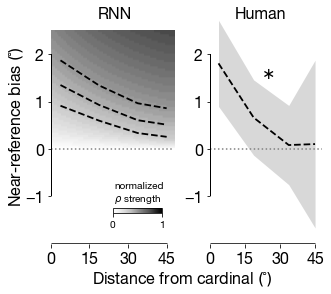

In [13]:
f, ax = plt.subplots(1,2,figsize=[4.7,3.9],gridspec_kw={'width_ratios':[1.1,1]})

xxxx = np.array( [3.75, 15+3.75, 30+3.75, 45] )
im = ax[0].imshow(grid_z, extent=(0,48,-2,2.5), origin='lower', aspect='auto', cmap='Greys', clim=[0,1])
ax[0].plot(xxxx, nrb_het_group[11,-1,:]*90/np.pi, color='k', lw=1.8, linestyle='dashed')
ax[0].plot(xxxx, nrb_het_group[14,-1,:]*90/np.pi, color='k', lw=1.8, linestyle='dashed')
ax[0].plot(xxxx, nrb_het_group[17,-1,:]*90/np.pi, color='k', lw=1.8, linestyle='dashed')
ax[0].axhline(y=0, linestyle='dotted', color='gray')
ax[0].set_ylabel(r"Near-reference bias $(\!\!^\circ\!\!)$", labelpad=0, size=16)
ax[0].set_ylim([-2,3])

#
ax[1].fill_between(xxxx, lin_params[:,2]-lin_ses[:,2], lin_params[:,2]+lin_ses[:,2], 
                   zorder=-1, alpha=0.3, linewidth=0, color='gray')
ax[1].plot(xxxx, lin_params[:,2], color='k', lw=1.8, linestyle='dashed')
ax[1].axhline(y=0, linestyle='dotted', color='gray')
ax[1].set_xlim([0,48])
ax[1].set_ylim([-2,3])

utils.draw_publish_axis(ax[0], xrange=(0,45), yrange=(-1,2), xticks=[0,15,30,45], yticks=[-1,0,1,2])

utils.draw_publish_axis(ax[1], xrange=(0,45), yrange=(-1,2), xticks=[0,15,30,45], yticks=[-1,0,1,2])

#
cax = inset_axes(ax[0], width="100%", height="20%",
                 bbox_to_anchor=(0.5, 0.05, 0.4, 0.1), bbox_transform=ax[0].transAxes, borderpad=0)
cb = plt.colorbar(im, cax=cax, orientation="horizontal")
cb.ax.tick_params(labelsize=10)
cb.set_ticks([0,1])
cb.set_ticklabels(['0', '1'])
ax[0].text(24.5, -1.1, 'normalized' '\n' r'$\rho$ strength', size=10)

f.subplots_adjust(wspace=0.3)
f.text(0.55,-0.02, r"Distance from cardinal $(\!\!^\circ\!\!)$", ha='center', size=16)
f.text(0.35, 0.92, "RNN",  ha='center', size=16)
f.text(0.78, 0.92, "Human", ha='center', size=16)
ax[1].text(22,1.5, r'$\ast$', size=16)

plt.savefig(f'{utils.DIR_FIGURE}/fig8fg.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [14]:
# individual-level choice-induced biases
lin_params_indiv = np.nan*np.zeros( (50, len(stim_groups), 3) )

for i_sub, v_sub in enumerate( np.unique(behavior['ID']) ):
    
    ## individual data 
    sub_behav = behavior[ behavior['ID']==v_sub ]
    
    ## evidence and choices
    data = {
        'evidence' : -sub_behav.ref.to_numpy(),
        'choice'   : 2.-sub_behav.choice.to_numpy(),
    }
    psi.fit( data )

    for i_stim, v_stim in enumerate( stim_groups ):
        grp_sub_behav = behavior[ np.isin(behavior.stim, v_stim) & (behavior['ID']==v_sub) ]
        
        ## reference and errors
        ref   = grp_sub_behav.ref.to_numpy()
        error = grp_sub_behav.error.to_numpy()
        diff  = 2.*psi( -ref, **dict( zip(psi.param_names, psi.fitted_params) ) ) - 1.
        diff[np.abs(ref) > thres] = 0.

        ## 
        X = np.array([ref,diff]).T
        X = sm.add_constant(X)
        y = error
        
        summ = sm.OLS(y, X).fit()
        lin_params_indiv[i_sub, i_stim] = summ.params

pearsonrs = [pearsonr(np.log(xxxx), lin_params_indiv[i_sub,:,2])[0] for i_sub in range(50)]
ttest  = DescrStatsW(pearsonrs)
wilcox = wilcoxon(pearsonrs)

print("Bias correlations vs. 0")
print('\nIndependent samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Bias correlations vs. 0

Independent samples t-test
t(49)= -2.2295302026433625 p= 0.03039430017842043
95% CI= (-0.33496083275995203, -0.017380152580597386)

Wilcoxon signed-rank test (without continuity correction)
V= 446.0 p= 0.06451517853717512
